In [1]:

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.
# font set
font_path = '/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=3)


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [2]:
## 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):

    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열
    # window 개씩 이동 평균을 냄.
#     print(timeseries)
#     print(rolmean)
#     print(rolstd)
    
     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    #plt.ylim(7,10)
    plt.show(block=False)
    
#함수정의
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)



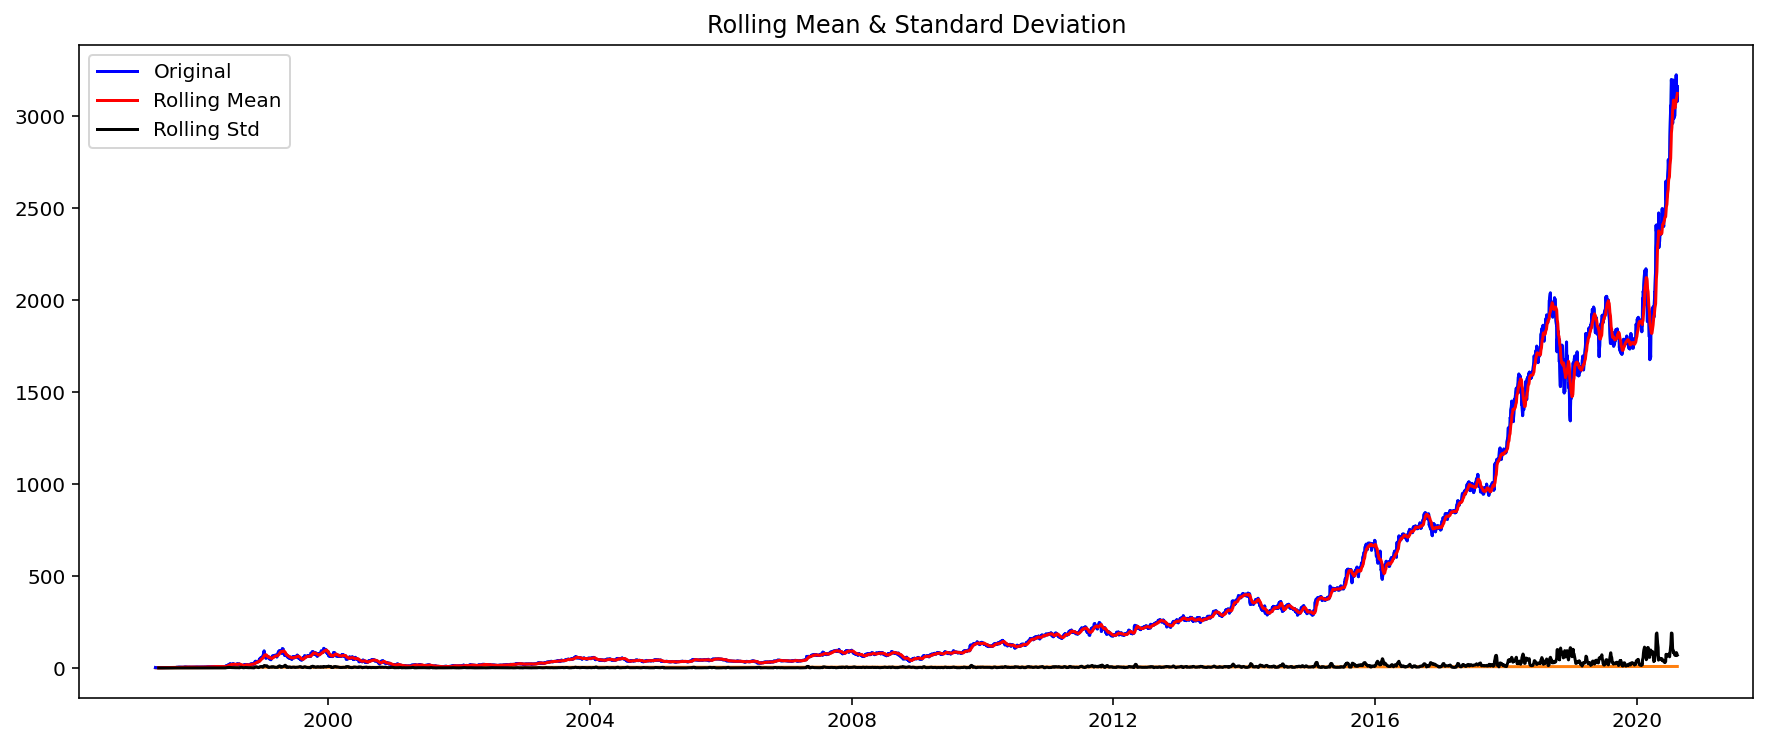

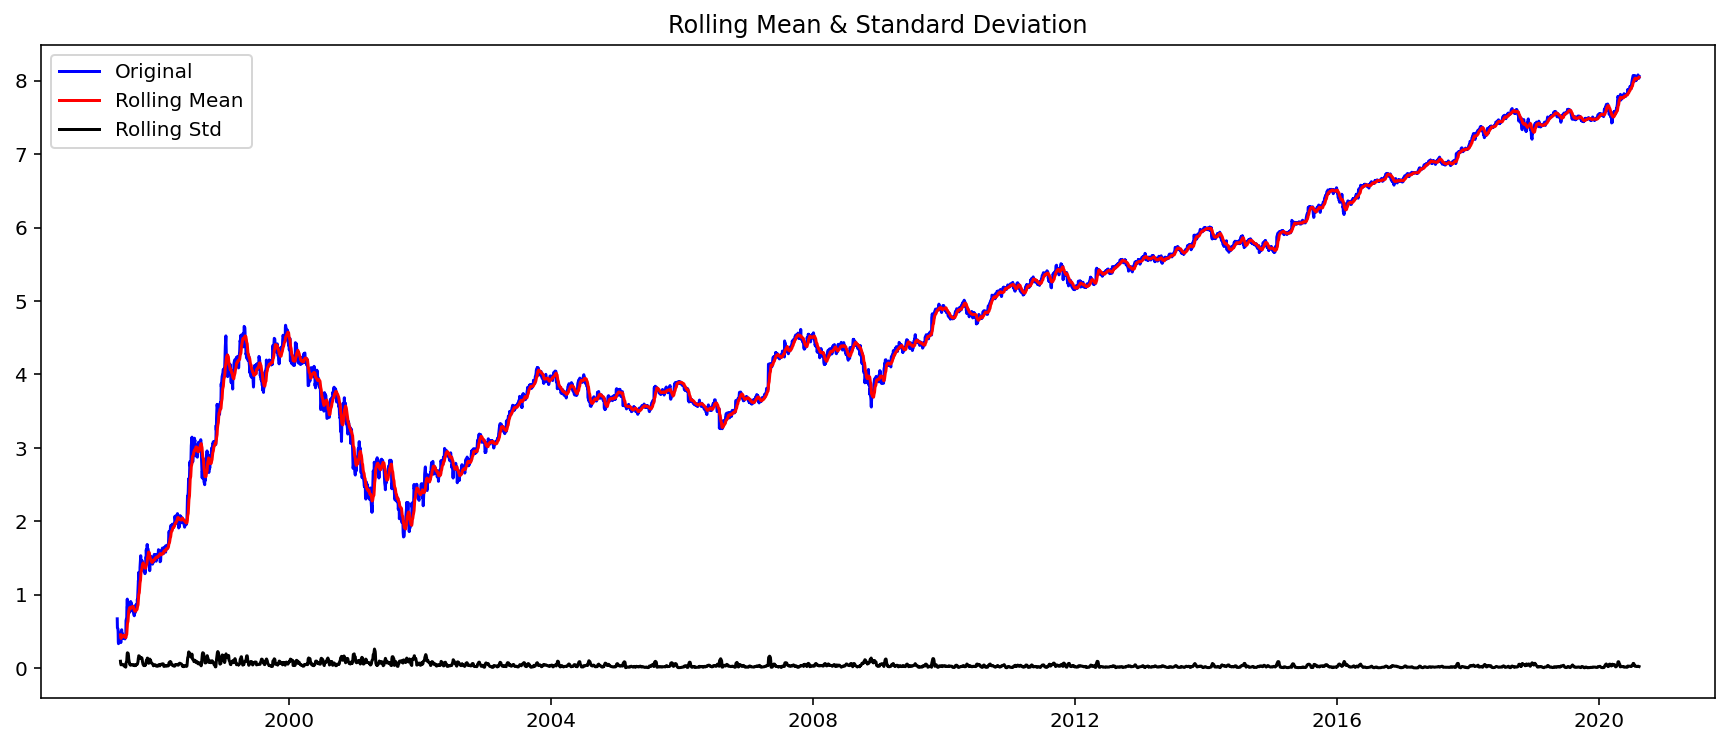

Results of Dickey-Fuller Test:
Test Statistic                   -1.508402
p-value                           0.529351
#Lags Used                       34.000000
Number of Observations Used    5815.000000
Critical Value (1%)              -3.431475
Critical Value (5%)              -2.862037
Critical Value (10%)             -2.567035
dtype: float64


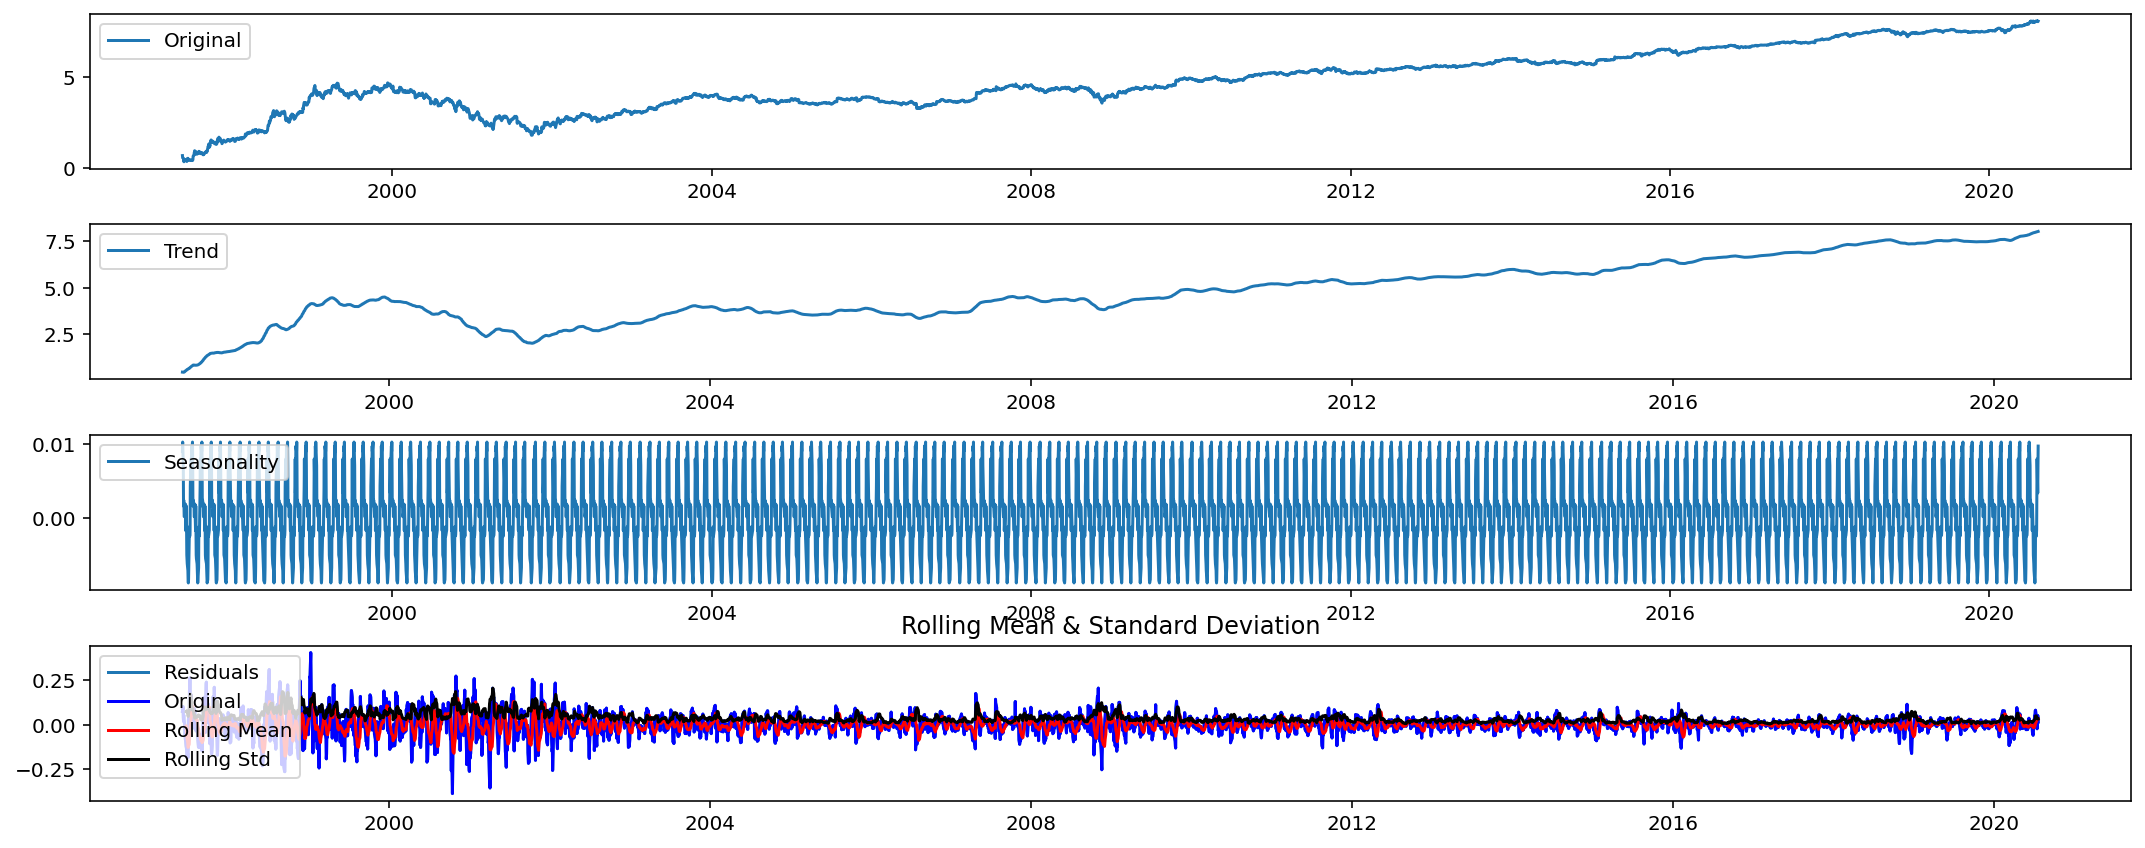

Results of Dickey-Fuller Test:
Test Statistic                -1.800433e+01
p-value                        2.727698e-30
#Lags Used                     3.400000e+01
Number of Observations Used    5.785000e+03
Critical Value (1%)           -3.431481e+00
Critical Value (5%)           -2.862040e+00
Critical Value (10%)          -2.567036e+00
dtype: float64
Date
1997-05-15    0.672094
1997-05-16    0.547640
Name: Close, dtype: float64
(5557,)
(293,)


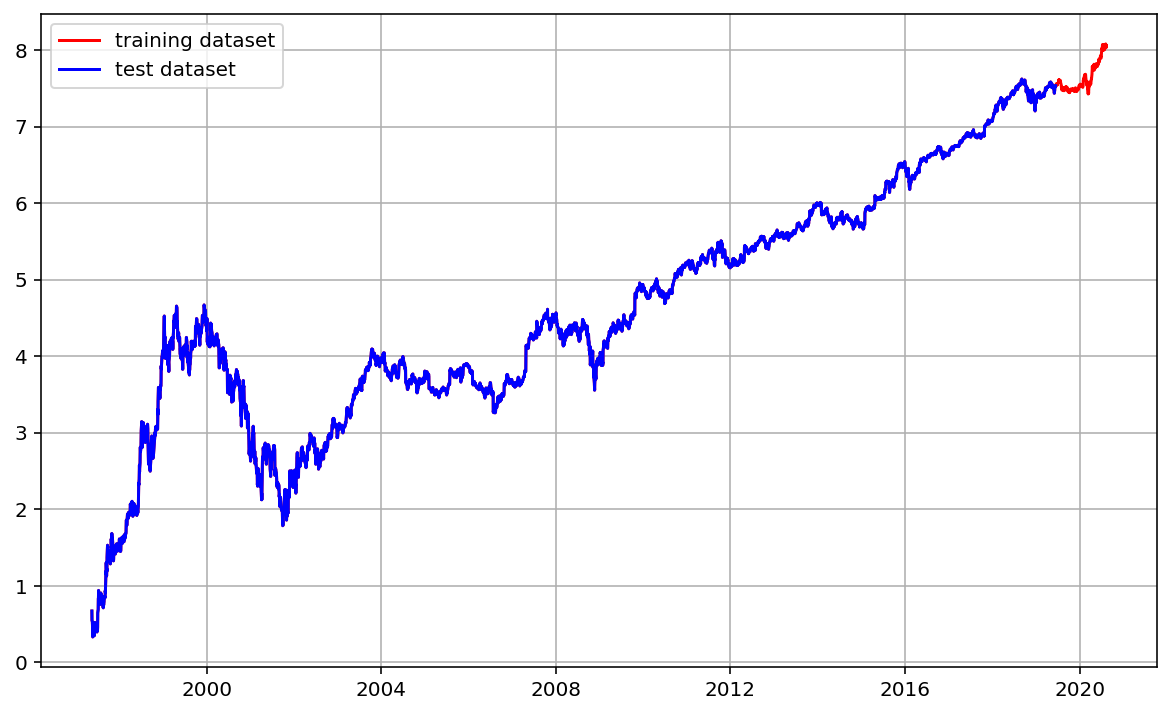

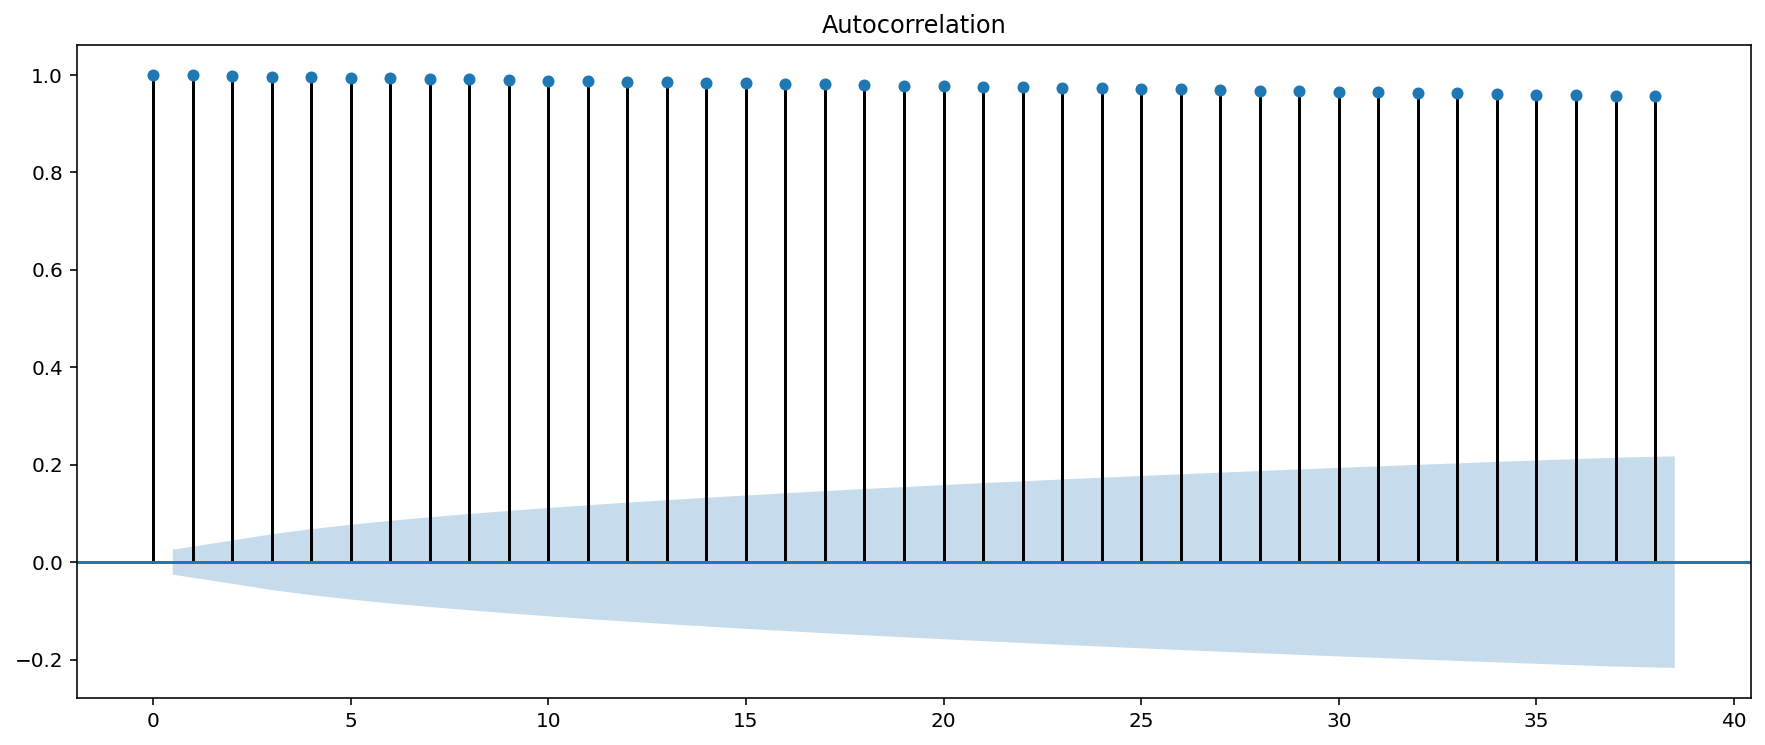

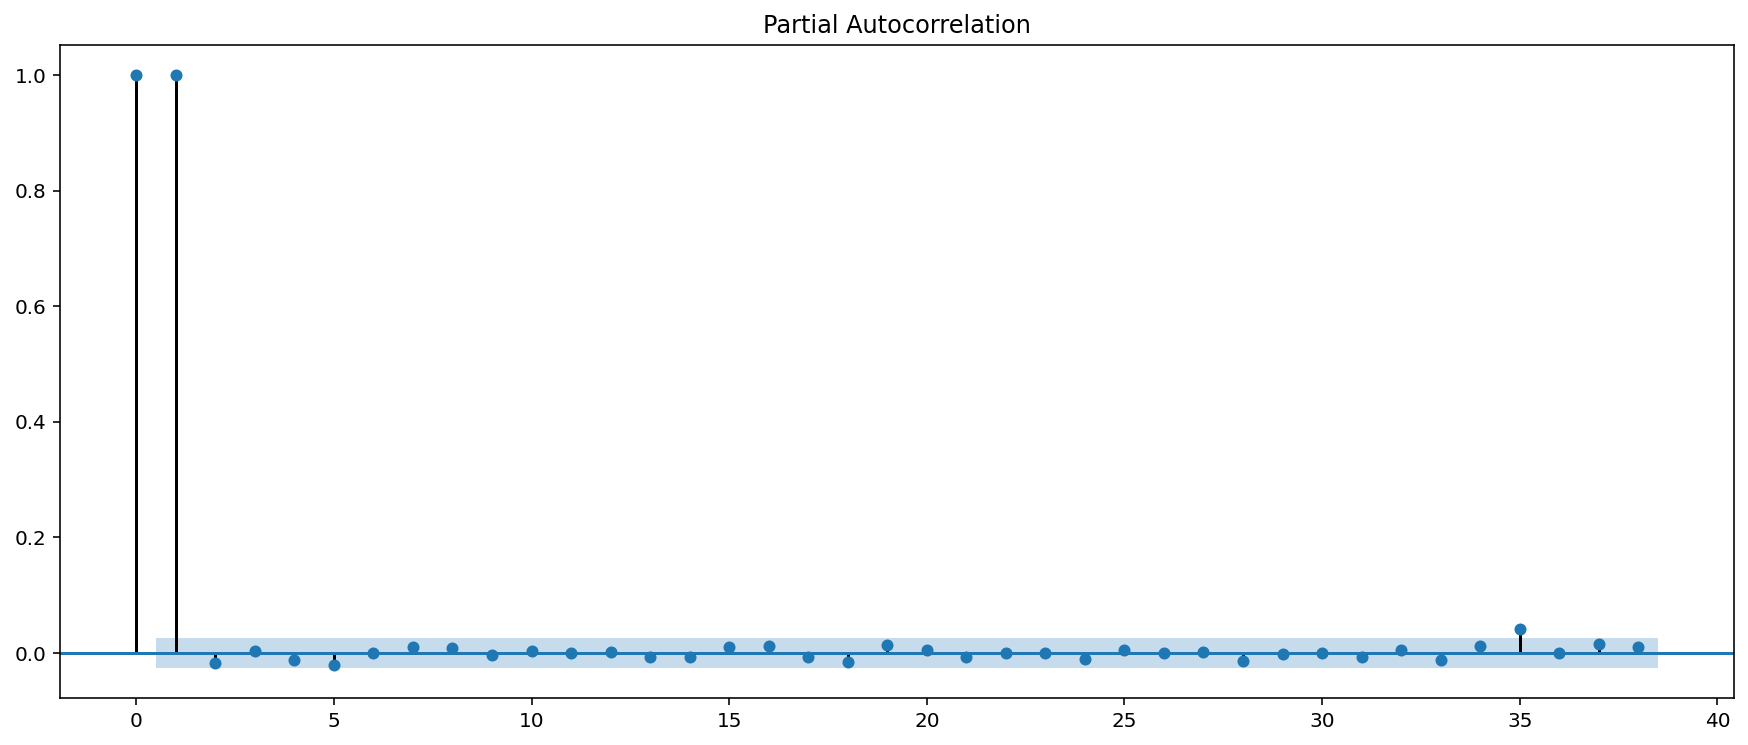

Results of Dickey-Fuller Test:
Test Statistic                -1.303417e+01
p-value                        2.311740e-24
#Lags Used                     3.300000e+01
Number of Observations Used    5.815000e+03
Critical Value (1%)           -3.431475e+00
Critical Value (5%)           -2.862037e+00
Critical Value (10%)          -2.567035e+00
dtype: float64


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
#data import
file_path_apple = './data/amzon.csv'
#file_path_apple = os.getenv('HOME')+'/aiffel/AIFFEL_LSG/lms/E06-Stationary_Time_Series/data/asiana_airlines.csv' 

facebook = pd.read_csv(file_path_apple, index_col="Date", parse_dates=True)
facebook.head()

#series object exprot
apple_s = facebook['Close']
apple_s.head()

#전처리
apple_s = apple_s.interpolate(method="time")
apple_s[apple_s.isna()]
plt.plot(apple_s)

# 로그 함수 씌우기
apple_s_log = np.log(apple_s)
plt.plot(apple_s_log)

#
#로그 전.
plot_rolling_statistics(apple_s, window=12)
# 로그 후.
plot_rolling_statistics(apple_s_log, window=12)

augmented_dickey_fuller_test(apple_s_log)

# 시계열 분석

decomposition = seasonal_decompose(apple_s_log, period = 30)  #Multiplicative

trend = decomposition.trend
seasonal = decomposition.seasonal
residual= decomposition.resid

plt.subplot(411)
plt.plot(apple_s_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# 안정성 확인
# Residual 로 확인
plot_rolling_statistics(residual) # 그래프
residual.dropna(inplace=True) # nan 제거
augmented_dickey_fuller_test(residual) # 귀무가설 확인

# train, test data spilt
train_apple_data, test_apple_data = apple_s_log[:int(len(apple_s_log)*0.95)], apple_s_log[int(len(apple_s_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(apple_s_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(train_apple_data, c='b', label='test dataset')
plt.legend()

# data set check
print(apple_s_log[:2])
print(train_apple_data.shape)
print(test_apple_data.shape)


plot_acf(apple_s_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(apple_s_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# 1차 차분 구하기
diff_1 = apple_s_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


#훈련


# Build and Train  Model
model = ARIMA(train_apple_data, order=(0, 1, 100))
fit_model = model.fit(disp=-1)
print(fit_model.summary())

fit_model.plot_predict()

# 데이터 구간
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fit_model.forecast(len(test_apple_data), alpha=0.05)  # 95% conf
#   step , 
# alpha 


# Make as pandas series
fc_series = pd.Series(fc, index=test_apple_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_apple_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_apple_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_apple_data, label='training')
plt.plot(test_apple_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_apple_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_apple_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_apple_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_apple_data))/np.abs(np.exp(test_apple_data)))
print('MAPE: {:.2f}%'.format(mape*100))